1. Camera Calibration
=======================

In [1]:
import matplotlib
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import pickle

In [2]:
# Arrays to store object points and image points from all the images
objpoints = []   # 3D points in real world space
imgpoints = []   # 2D points in image plane

nx = 9
ny = 6


# Prepare object pionts, like(0, 0, 0), (1, 0, 0) , (2,0,0) ..,(6,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinates


In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
            30, 0.001)

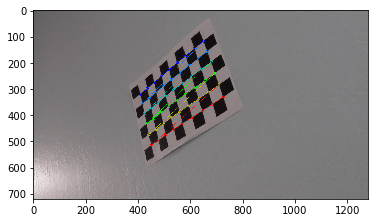

In [4]:
images = glob.glob('camera_cal/*.jpg')

# Go through all images and find corners
for fname in images:
    
    # read in an image
    img = cv2.imread(fname)
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        
    else:
        print('Warning: ret = {} for {}'.format(ret, fname))

2. Distortion correction
===========================

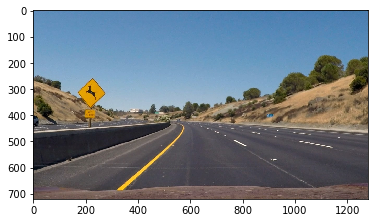

In [5]:

img = plt.imread('test_images/test2.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)


In [6]:
# Calibrate camera and undistort a test image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                  imgpoints,
                                                  img_size,
                                                  None, None)

In [7]:
dst = cv2.undistort(img, mtx, dist, None, mtx)

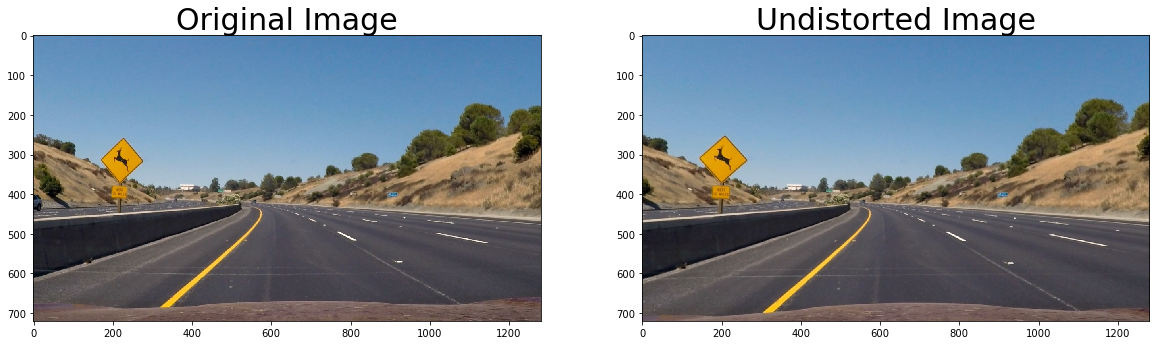

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

3. Color and Gradient Thresholding
=====================

In [9]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    thresh_min,thresh_max = thresh[0],thresh[1]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.absolute(np.arctan2(abs_sobely, abs_sobelx))
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

def hls_thresh(img, thresh=(100, 255)):
    # convert RGB to HLS and threshold to binary image using
    # S channel
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def pipeline(img, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50,100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50,100 ))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 205))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_thresh(image, thresh=(170, 255))
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary == 1)] = 1
    
    return gradx, grady, mag_binary, dir_binary, hls_binary, combined



    

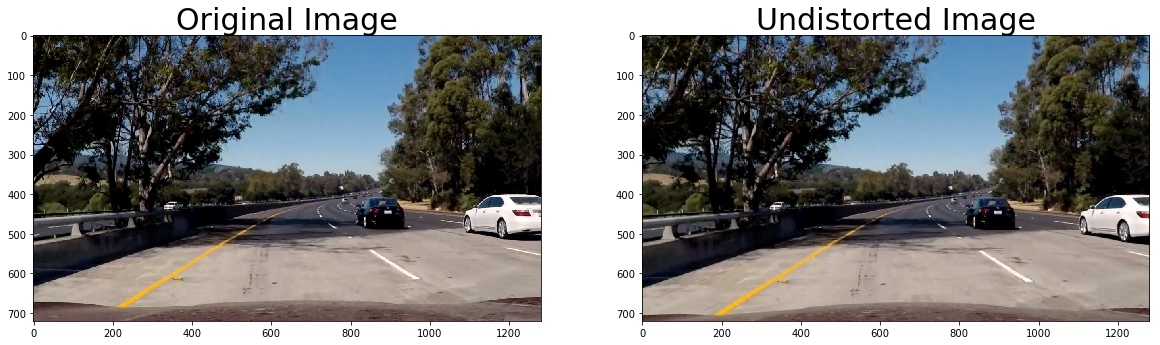

In [10]:
# Read in an image
#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test5.jpg') 
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements


image_undistort = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [11]:
gradx, grady, mag_binary, dir_binary, hls_binary, combined = pipeline(image_undistort, ksize)

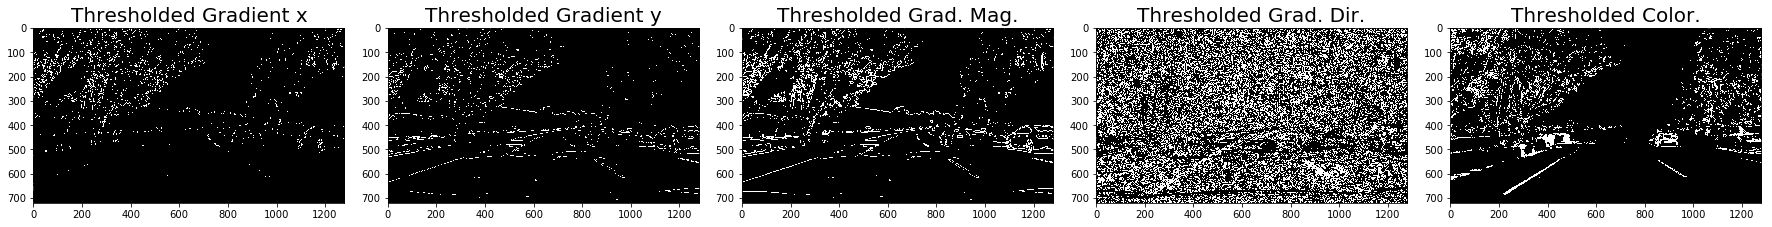

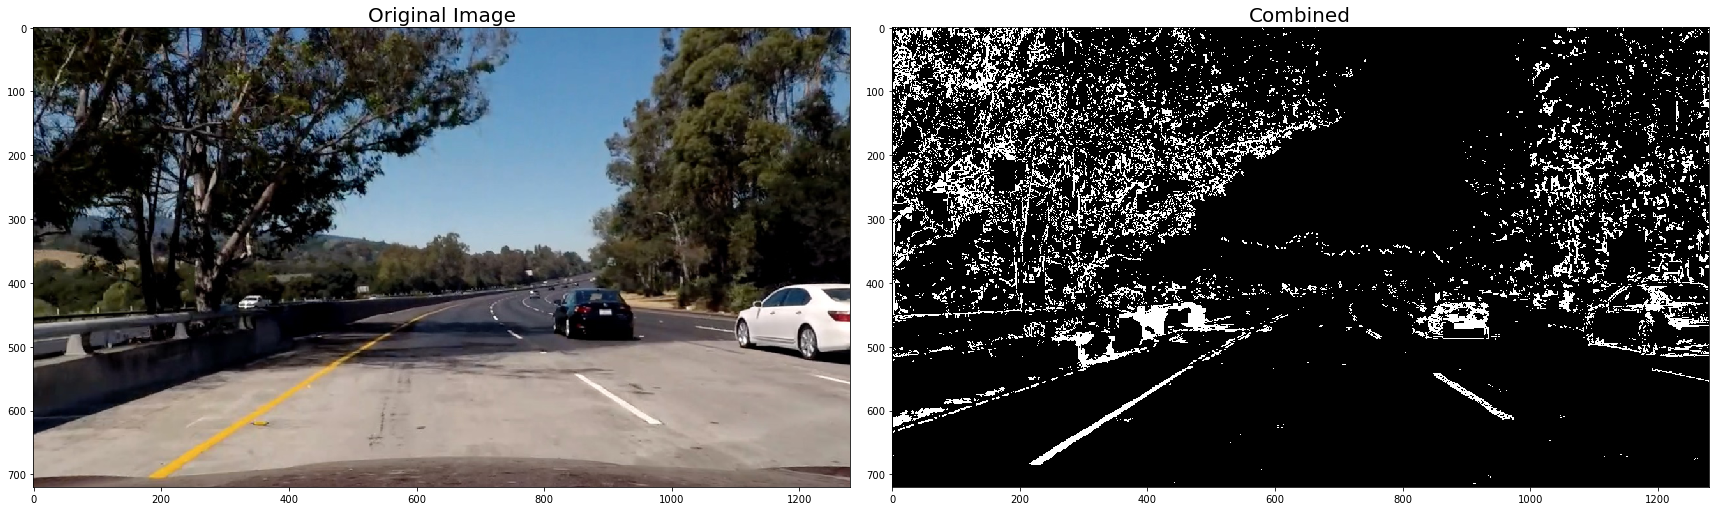

In [12]:

# Plot the results
fontsize=20
f, (ax1, ax2,ax3,ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Thresholded Gradient x', fontsize=fontsize)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Thresholded Gradient y', fontsize=fontsize)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Thresholded Grad. Mag.', fontsize=fontsize)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Thresholded Grad. Dir.', fontsize=fontsize)
ax5.imshow(hls_binary, cmap='gray')
ax5.set_title('Thresholded Color.', fontsize=fontsize)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_undistort)
ax1.set_title('Original Image', fontsize=fontsize)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=fontsize)

In [13]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
              [[200, 720],
               [1100, 720],
               [595, 450],
               [685, 450]])
    
    dst = np.float32(
               [[300, 720],
               [980, 720],
               [300, 0],
               [980, 0]])
    
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(img, m_inv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, unwarped, m, m_inv
    

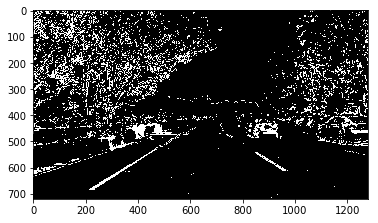

In [14]:
img = np.copy(combined)
plt.imshow(img, cmap='gray')

In [15]:
warped, unwarped, m, m_inv = perspective_transform(img)

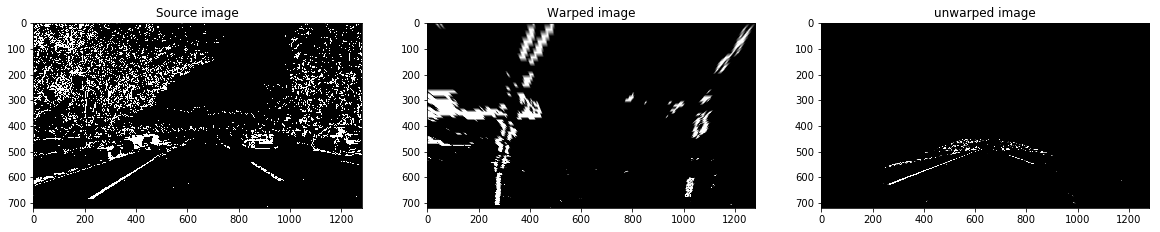

In [16]:
# Visualize Perspective transform 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.set_title('Source image')
ax1.imshow(img, cmap='gray')

ax2.set_title('Warped image')
ax2.imshow(warped, cmap='gray')

ax3.set_title('unwarped image')
ax3.imshow(unwarped, cmap='gray')

plt.show()

4. Define a class to receive the characteristics of each line detection
========================================================================

In [17]:
class Line():
    def __init__(self, n):
        # n is the window size of the moving average
        
        self.n = n
        self.detected = False
        
        # Polynomial coefficients: x = A*y^2 + B*y + C
        # Each of A, B, C is a list-queue with max length n
        self.A = []
        self.B = []
        self.C = []
        
        # Average of above
        self.A_avg = 0.
        self.B_avg = 0.
        self.C_avg = 0.
        
    def get_fit(self):
        return (self.A_avg, self.B_avg, self.C_avg)
    
    def add_fit(self, fit_coeffs):
        """
        - Gets most recent line fit coefficients and updates internal 
        smoothed ciefficients.
        - fit_coeffs is a 3 element list of 2nd order polynomial coefficients
        """
        
        # Coefficient queue full?
        q_full = len(self.A) >= self.n
        
        # Append line fit coefficients
        self.A.append(fit_coeffs[0])
        self.B.append(fit_coeffs[1])
        self.C.append(fit_coeffs[2])
        
        # Pop from index 0 if full
        if q_full:
            _ = self.A.pop(0)
            _ = self.B.pop(0)
            _ = self.C.pop(0)
            
        # Simple average of line coefficients
        self.A_avg = np.mean(self.A)
        self.B_avg = np.mean(self.B)
        self.C_avg = np.mean(self.C)
        
        return (self.A_avg, self.B_avg, self.C_avg)
        


## Finding and Fitting lane lines


In [18]:
def line_fit(binary_warped):
    # Assuming we have created a warped binary image called "binary_warped:.
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    
    # Find the peak of the left and right halves of the histogram 
    # These will be starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[100:midpoint]) + 100
    rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint
    
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/ nwindows)
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin 
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0]  - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, 
                      (win_xleft_low, win_y_low),
                     (win_xleft_high, win_y_high),
                     (0,255,0),
                     2)
        cv2.rectangle(out_img,
                     (win_xright_low, win_y_low),
                     (win_xright_high, win_y_high),
                     (0, 255, 0),
                     2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        
        # Fit a second order polynomial to each 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Return a dictionary of relevant variables
        ret = {}
        ret['left_fit'] = left_fit
        ret['right_fit'] = right_fit
        ret['nonzerox'] = nonzerox
        ret['nonzeroy'] = nonzeroy
        ret['out_img'] = out_img
        ret['left_lane_inds'] = left_lane_inds
        ret['right_lane_inds'] = right_lane_inds
        
        return ret

In [26]:

def tune_fit(binary_warped, left_fit, right_fit):
    """
    Given a previously fit line, quickly try to find the line based on previous lines
    """
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If we don't find enough relevant points, return all None (this means error)
    min_inds = 10
    if lefty.shape[0] < min_inds or righty.shape[0] < min_inds:
        return None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Return a dict of relevant variables
    ret = {}
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    ret['nonzerox'] = nonzerox
    ret['nonzeroy'] = nonzeroy
    ret['left_lane_inds'] = left_lane_inds
    ret['right_lane_inds'] = right_lane_inds

    return ret

Visualize each sliding window location and predicted lane lines, on binary warped image.

save_file is a string representing where to save the image (if None, then just display)

In [19]:
def viz1(binary_warped, ret, save_file=None):
    # Grab variables from ret dictionary
    
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    out_img = ret['out_img']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']
    
    # Generate x and y values for plotting
    ploty = np.linspace(0,
                       binary_warped.shape[0]-1,
                       binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    if save_file is None:
        plt.show()
        
    else:
        plt.savefig(save_file)
    plt.gcf().clear()

Visualize the predicted lane lines with margin, on binary warped image

save_file is a string representing where to save the image (if None, then just display)

In [20]:
def viz2(binary_warped, ret, save_file=None):
    # Grab variables from ret dictionary
    
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    out_img = ret['out_img']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']
    
    # Create an image to draw on and an image to show 
    # the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds],
           nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds],
           nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0,
                       binary_warped.shape[0]-1,
                       binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillpoly()
    
    margin = 100 # NOTE: keep this in sync wiht *_fit()
    left_line_window1 = np.array([np.transpose(
                     np.vstack([left_fitx - margin, ploty]))])
    
    left_line_window2 = np.array([np.flipud(np.transpose(
                      np.vstack([left_fitx + margin, ploty])))])
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    
    right_line_window1 = np.array([np.transpose(
                     np.vstack([right_fitx - margin, ploty]))])
    
    right_line_window2 = np.array([np.flipud(np.transpose(
                      np.vstack([right_fitx + margin, ploty])))])
    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color="yellow")
    plt.plot(right_fitx, ploty, color="yellow")
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    if save_file is None:
        plt.show()
        
    else:
        plt.savefig(save_file)
        
    plt.gcf().clear()
    
    

### Calculate the radius of curvature in meters


In [21]:
def calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    
    y_eval = 719 # 720p video/image, so last (lowest on screen) y index is 719
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)\
    / np.absolute(2*left_fit_cr[0])
    
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)\
    / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad



In [22]:
def calc_vehicle_offset(undist, left_fit, right_fit):
    """
        Calculate vehicle offset from lane center, in meters
    """
    # Calculate vehicle center offset in pixels
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    # Convert pixel offset to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    return vehicle_offset

In [23]:

def final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset):
    """
    Final lane line prediction visualized and overlayed on top of original image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')  # NOTE: Hard-coded image dimensions

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curve + right_curve)/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.1f m' % vehicle_offset
    result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    return result


## Lane fit Video

In [24]:
from moviepy.editor import VideoFileClip

In [25]:
# Global variables
with open('calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
    
mtx = save_dict['mtx']
dist = save_dict['dist']
window_size = 5  # how many frames for line smoothing
left_line = Line(n=window_size)
right_line = Line(n=window_size)
detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0. # radius of curvature for left and right lane
left_lane_inds, right_lane_inds = None, None # for calculating curvature

MoviePy video annotation will call this function

In [29]:
def annotate_image(img_in):
    """
    Annotate the input image with lane line markings
    Returns annotated image
    """
    global mtx, dist, left_line, right_line, detected
    global left_curve, right_curve, left_lane_inds, right_lane_inds
    ksize = 5
    
    # Undistort, threshold, perspective transform 
    undist = cv2.undistort(img_in, mtx, dist, None, mtx)
    gradx, grady, mag_binary, dir_binary, hls_binary, combined = pipeline(undist, ksize)
    binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)
    
    
    # Perform polynomial fit
    if not detected:
        # Slow line fit
        ret = line_fit(binary_warped)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']
        
        # Get moving average of line fit coefficients
        left_fit = left_line.add_fit(left_fit)
        right_fit = right_line.add_fit(right_fit)
        
        # Calculate curvature
        left_curve, right_curve = calc_curve(left_lane_inds, 
                                            right_lane_inds,
                                            nonzeroz, nonzeroy)
        
        detected = True # Slow line fit always detects the line
        
        
    else: # implies detected == True
        # Fast line fit
        left_fit = left_line.get_fit()
        right_fit = right_line.get_fit()
        ret = tune_fit(binary_warped, left_fit, right_fit)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']
        
        # Only make updates if we detected lines in current frame
        if ret is not None:
            left_fit = ret['left_fit']
            right_fit = ret['right_fit']
            nonzerox = ret['nonzerox']
            nonzeroy = ret['nonzeroy']
            left_lane_inds = ret['left_lane_inds']
            right_lane_inds = ret['right_lane_inds']

            left_fit = left_line.add_fit(left_fit)
            right_fit = right_line.add_fit(right_fit)
            left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

        else:
            detected = False
            
    vehicle_offset = calc_vehicle_offset(undist, left_fit, right_fit)
    
    # Perform final visualization on top of original undistorted image
    result = final_viz(undist, left_fit, right_fit, m_inv, left_curve,
                      right_curve, vehicle_offset)
    
    return result


In [30]:
def annotate_video(input_file, output_file):
    """
    Given input_file video, save annotated video to output_file
    """
    video = VideoFileClip(input_file)
    annotate_video = video.fl_image(annotate_image)
    annotate_video.write_videofile(output_file, audio=False)

In [32]:
annotate_video('project_video.mp4', 'out.mp4')

# Show example annotated image on screen for sanity check
img_file = 'test_images/test2.jpg'
img = mpimg.imread(img_file)
result = annotate_image(img)
result = annotate_image(img)
result = annotate_image(img)
plt.imshow(result)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices